# LLMOps with DeepEval

# 1. Overview
LLMOps covers:
1. **Testing**
2. **Evaluation**
3. **Monitoring**
4. Infrastructure
5. Orchestration
6. Deployment

We will discuss how to use the [DeepEval library](https://deepeval.com/) (and Confident-AI platform) to help you with 1,2 and 3.

Deepeval can help you with [end-to-end evaluations](https://deepeval.com/docs/evaluation-end-to-end-llm-evals) as in:

![image.png](attachment:dccee80f-951b-4110-8aa5-4c6e180ffc91.png)

You can also use it for [tracing](https://deepeval.com/docs/evaluation-llm-tracing) and for [component level evals](https://deepeval.com/docs/evaluation-component-level-llm-evals) as in

![image.png](attachment:761dd65b-8c7b-4593-b125-b08a81bbb536.png)


Rest of the talk:

2. **Main Concepts**
    1. `LLMTestCase` and `ConversationalTestCase`
    2.  Metrics and Test Execution
    3. `Golden`
    4. Datasets (`EvaluationDataset`)

3. **Example - RAG Agent**

4. **Execution (More Examples)**
    1. Unit test`deepeval test`
    2. Callback
    3. Batch

**Resources**
- https://github.com/confident-ai/deepeval/blob/main/examples/notebooks/langgraph.ipynb

In [1]:
# HOUSEKEEPING
from dotenv import load_dotenv
import os
load_dotenv()
OPEN_API_KEY = os.environ["OPENAI_API_KEY"]

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

# 2. Main Concepts
1. `LLMTestCase` and `ConversationalTestCase`
2.  Metrics and Test Execution
3. `Golden`
4. Datasets (`EvaluationDataset`)


## 2.1 `LLMTestCase` and `ConversationalTestCase`

In [2]:
from deepeval.test_case import LLMTestCase

# Note: You're input is the actual input from the user/prompt, not your full prompt template.
test_case = LLMTestCase(
        input="I have a persistent cough and fever. Should I be worried?",
        # Replace this with the actual output from your LLM application
        actual_output="A persistent cough and fever could be a viral infection or something more serious. See a doctor if symptoms worsen or don't improve in a few days.",
        expected_output="A persistent cough and fever could indicate a range of illnesses, from a mild viral infection to more serious conditions like pneumonia or COVID-19. You should seek medical attention if your symptoms worsen, persist for more than a few days, or are accompanied by difficulty breathing, chest pain, or other concerning signs.",
        context=["The British Medical Association states that coughs are bad."], # --> The IDEAL retrieved context
        retrieval_context=[
            "According to Wikipedia, the Second Punic War was totally awesome for Hannibal.", 
            "The Brtish Medical Association said that flu is bad",
            "According to quantum field theory, the vaccum energy is non-zero due to field fluctuations and virtual particles"
        ]   
    )

In [3]:
from deepeval.test_case import ConversationalTestCase, Turn

# Note: Annoyingly the "turns" are expected each as a single object, doesn't seem you can just pass a conversation history.
# This is similar to behaviour seen with test cases, where you have to create each individual test case in your set before evaluating.
conversational_test_case = ConversationalTestCase(
    scenario="User chit-chatting randomly with AI.",
    expected_outcome="AI should respond in friendly manner.",
    turns=[
        Turn(role="user", content="How are you doing?"),
        Turn(role="assistant", content="Why do you care?")
    ]
)

### 2.1.1 OpenAI Conversation API example

In [4]:
%%skip
from openai import OpenAI
client = OpenAI()

# Response
items = client.conversations.items.list("conv_123", limit=10)
print(items.data)

### 2.1.2 Bedrock Converse API Example
Resources
- https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-runtime/client/converse.html
- https://docs.aws.amazon.com/bedrock/latest/userguide/conversation-inference-examples.html

In [5]:
%%skip
import boto3

bedrock_client = boto3.client(service_name='bedrock-runtime')

# Start the conversation with the 1st message.
messages.append(message_1)
response = generate_conversation(
    bedrock_client, model_id, system_prompts, messages)

# Add the response message to the conversation.
output_message = response['output']['message']
messages.append(output_message)

# Continue the conversation with the 2nd message.
messages.append(message_2)
response = generate_conversation(
    bedrock_client, model_id, system_prompts, messages)

output_message = response['output']['message']
messages.append(output_message)

# Show the complete conversation.
for message in messages:
    print(f"Role: {message['role']}")
    for content in message['content']:
        print(f"Text: {content['text']}")
    print()

## 2.2 Metrics and Test Execution
https://deepeval.com/docs/metrics-introduction#quick-summary

<em>Almost all predefined metrics on deepeval uses **LLM-as-a-judge**, with various techniques such as QAG (question-answer-generation), DAG (deep acyclic graphs), and G-Eval to score test cases, which represents atomic interactions with your LLM app.</em>

<em>All of deepeval's metrics output a score **between 0-1 based on its corresponding equation**, as well as score reasoning. A metric is only successful if the evaluation score is equal to or greater than threshold, which is defaulted to 0.5 for all metrics.</em>

In [6]:
from deepeval.metrics import AnswerRelevancyMetric, FaithfulnessMetric, ContextualRelevancyMetric
answer_relevancy_metric = AnswerRelevancyMetric(
    threshold=0.7, #
    model="gpt-4o",
    include_reason=True
)
faithfulness_metric = FaithfulnessMetric(
    threshold=0.7,
    model="gpt-4o",
    include_reason=True
)
contextual_relevancy_metric = ContextualRelevancyMetric(
    threshold=0.7,
    model="gpt-4o",
    include_reason=True
)

In [7]:
answer_relevancy_metric.measure(test_case)
print(answer_relevancy_metric.score, answer_relevancy_metric.reason)

Output()

1.0 The score is 1.00 because the response was perfectly relevant, directly addressing the concern about a persistent cough and fever without any irrelevant information. Great job on staying focused and providing a clear answer!


In [8]:
faithfulness_metric.measure(test_case)
print(faithfulness_metric.score, faithfulness_metric.reason)

Output()

1.0 The score is 1.00 because there are no contradictions, indicating a perfect alignment between the actual output and the retrieval context. Keep up the great work!


In [9]:
contextual_relevancy_metric.measure(test_case)
print(contextual_relevancy_metric.score, contextual_relevancy_metric.reason)

Output()

0.0 The score is 0.00 because none of the statements in the retrieval context address the health concerns of having a persistent cough and fever. The provided statements discuss topics like the Second Punic War, flu in general, and quantum field theory, which are unrelated to the input's health query.


In [10]:
metrics = [answer_relevancy_metric, faithfulness_metric, contextual_relevancy_metric]

In [11]:
faithfulness_metric.__name__

'Faithfulness'

In [12]:
scores = {}
for metric in metrics:
    metric.measure(test_case)
    scores[metric.__name__] = metric.score 

Output()

Output()

Output()

In [13]:
scores

{'Answer Relevancy': 1.0, 'Faithfulness': 1.0, 'Contextual Relevancy': 0.0}

In [14]:
from deepeval import evaluate

evaluate(test_cases=[test_case], metrics=metrics)

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Contextual Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

Output()



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because the response was perfectly relevant, directly addressing the concern about a persistent cough and fever without any irrelevant information. Great job!, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because there are no contradictions between the actual output and the retrieval context. Everything aligns perfectly, showcasing a high level of accuracy and consistency. Keep up the great work!, error: None)
  - ❌ Contextual Relevancy (score: 0.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 0.00 because none of the statements in the retrieval context address the health concerns of having a persistent cough and fever, as highlighted by the irrelevancy of topics like the Second Punic War and quantum field theory., error: None)

For tes

✓ Evaluation completed 🎉! (time taken: 5.32s | token cost: 0.017542500000000003 USD)
» Test Results (1 total tests):
   » Pass Rate: 0.0% | Passed: 0 | Failed: 1

 ================================================================================ 

» What to share evals with your team, or a place for your test cases to live? ❤️ 🏡
  » Run 'deepeval view' to analyze and save testing results on Confident AI.

EvaluationResult(test_results=[TestResult(name='test_case_0', success=False, metrics_data=[MetricData(name='Answer Relevancy', threshold=0.7, success=True, score=1.0, reason='The score is 1.00 because the response was perfectly relevant, directly addressing the concern about a persistent cough and fever without any irrelevant information. Great job!', strict_mode=False, evaluation_model='gpt-4o', error=None, evaluation_cost=0.004455000000000001, verbose_logs='Statements:\n[\n    "A persistent cough and fever could be a viral infection.",\n    "It could be something more serious.",\n    "See a doctor if symptoms worsen.",\n    "See a doctor if symptoms don\'t improve in a few days."\n] \n \nVerdicts:\n[\n    {\n        "verdict": "yes",\n        "reason": null\n    },\n    {\n        "verdict": "yes",\n        "reason": null\n    },\n    {\n        "verdict": "yes",\n        "reason": null\n    },\n    {\n        "verdict": "yes",\n        "reason": null\n    }\n]'), MetricData(name='Fa

## 2.3 Goldens

https://deepeval.com/docs/evaluation-datasets#what-are-goldens
<div>
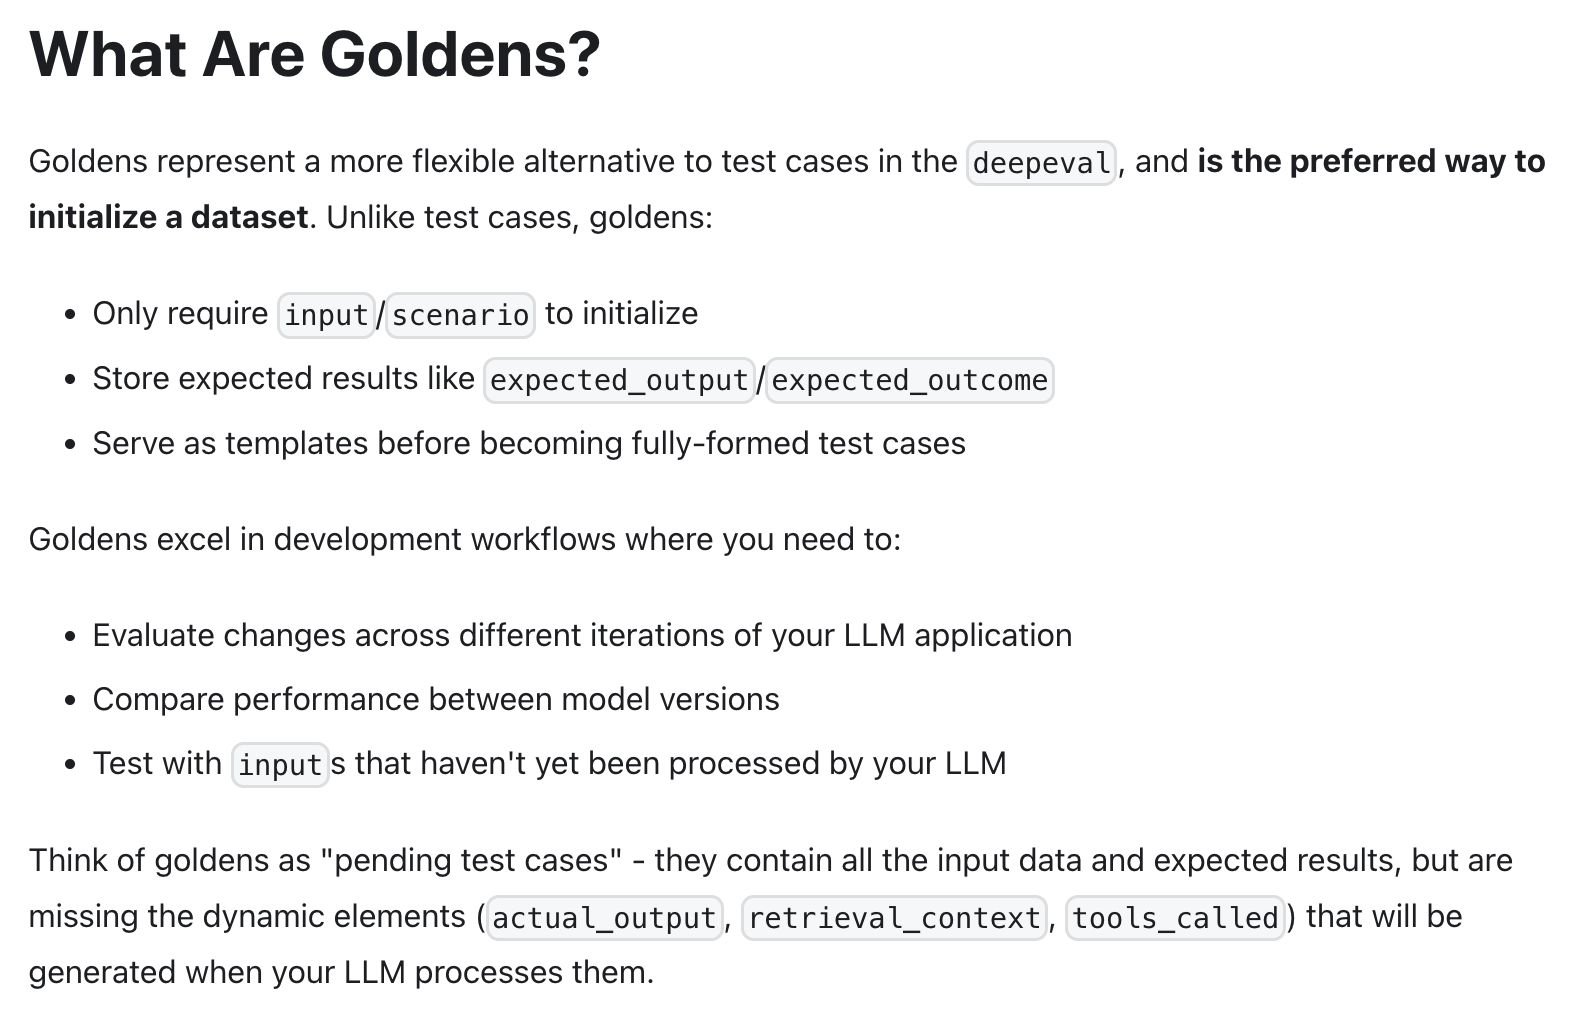
</div>


In [15]:
from deepeval.dataset import Golden

goldens = [
    Golden(input="I have a cough, should I be worried?"),
    Golden(input="Symptoms of Covid?"),
    Golden(input="What are your top tips for fitness?"),
    Golden(input="How many elephants did Hannibal have?"),
    Golden(input="What were Scylla and Charybdis in the Odyssey?"),
    Golden(input="How many steps should I take a day?"),
    Golden(input="What are some ways to get more steps in on a day?"),
    Golden(input="What is a good resting heart rate?"),
    Golden(input="What range of heart rate is normal?")
]

## 2.4 Datasets
A dataset is a collection of "goldens" or test cases.

Findings:
- They make sense for batch evals.
- The results structure is very nested, you need to do alot of unpacking to get results in bulk.
- Every entry has to be a `LLMTestCase` or `Golden` -> this is quite annoying if you want to work with large arrays of data for example.

In [16]:
from deepeval.dataset import EvaluationDataset, Golden

dataset = EvaluationDataset(
    goldens=goldens
)

In [17]:
dataset

EvaluationDataset(test_cases=[], goldens=[Golden(input='I have a cough, should I be worried?', actual_output=None, expected_output=None, context=None, retrieval_context=None, turns=None, additional_metadata=None, comments=None, tools_called=None, expected_tools=None, source_file=None, name=None, custom_column_key_values=None), Golden(input='Symptoms of Covid?', actual_output=None, expected_output=None, context=None, retrieval_context=None, turns=None, additional_metadata=None, comments=None, tools_called=None, expected_tools=None, source_file=None, name=None, custom_column_key_values=None), Golden(input='What are your top tips for fitness?', actual_output=None, expected_output=None, context=None, retrieval_context=None, turns=None, additional_metadata=None, comments=None, tools_called=None, expected_tools=None, source_file=None, name=None, custom_column_key_values=None), Golden(input='How many elephants did Hannibal have?', actual_output=None, expected_output=None, context=None, retrie

In [18]:
for golden in dataset.goldens:
    test_case = LLMTestCase(
        input=golden.input,
        actual_output="Eh, no idea mate ...",#your_llm_app(golden.input) # replace with your LLM app
        retrieval_context=["Daily Mail pg 7"]
    )
    dataset.add_test_case(test_case)

In [19]:
dataset.test_cases

[LLMTestCase(input='I have a cough, should I be worried?', actual_output='Eh, no idea mate ...', expected_output=None, context=None, retrieval_context=['Daily Mail pg 7'], additional_metadata=None, tools_called=None, comments=None, expected_tools=None, token_cost=None, completion_time=None, name=None, tags=None, mcp_servers=None, mcp_tools_called=None, mcp_resources_called=None, mcp_prompts_called=None),
 LLMTestCase(input='Symptoms of Covid?', actual_output='Eh, no idea mate ...', expected_output=None, context=None, retrieval_context=['Daily Mail pg 7'], additional_metadata=None, tools_called=None, comments=None, expected_tools=None, token_cost=None, completion_time=None, name=None, tags=None, mcp_servers=None, mcp_tools_called=None, mcp_resources_called=None, mcp_prompts_called=None),
 LLMTestCase(input='What are your top tips for fitness?', actual_output='Eh, no idea mate ...', expected_output=None, context=None, retrieval_context=['Daily Mail pg 7'], additional_metadata=None, tools

In [20]:
results = evaluate(test_cases=dataset.test_cases, metrics=metrics)

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Contextual Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

Output()



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because the response perfectly addressed the question about a good resting heart rate without any irrelevant information. Great job on staying focused and providing a clear answer!, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because there are no contradictions between the actual output and the retrieval context. Everything aligns perfectly, showcasing a high level of accuracy and consistency. Great job!, error: None)
  - ❌ Contextual Relevancy (score: 0.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 0.00 because the retrieval context lacks any relevant information about resting heart rates, as indicated by the absence of pertinent statements and the irrelevance of 'Daily Mail pg 7' to the topic., error: None)

For test case:

  - inp

✓ Evaluation completed 🎉! (time taken: 7.55s | token cost: 0.09888250000000001 USD)
» Test Results (9 total tests):
   » Pass Rate: 0.0% | Passed: 0 | Failed: 9

 ================================================================================ 

» What to share evals with your team, or a place for your test cases to live? ❤️ 🏡
  » Run 'deepeval view' to analyze and save testing results on Confident AI.

In [21]:
results

EvaluationResult(test_results=[TestResult(name='test_case_7', success=False, metrics_data=[MetricData(name='Answer Relevancy', threshold=0.7, success=True, score=1.0, reason='The score is 1.00 because the response perfectly addressed the question about a good resting heart rate without any irrelevant information. Great job on staying focused and providing a clear answer!', strict_mode=False, evaluation_model='gpt-4o', error=None, evaluation_cost=0.0037575000000000004, verbose_logs='Statements:\n[\n    "Eh, no idea mate ..."\n] \n \nVerdicts:\n[\n    {\n        "verdict": "idk",\n        "reason": null\n    }\n]'), MetricData(name='Faithfulness', threshold=0.7, success=True, score=1.0, reason='The score is 1.00 because there are no contradictions between the actual output and the retrieval context. Everything aligns perfectly, showcasing a high level of accuracy and consistency. Great job!', strict_mode=False, evaluation_model='gpt-4o', error=None, evaluation_cost=0.0030425, verbose_log

In [22]:
# Process results dataset into something readable
import pandas as pd
import json

def reformat_results(results: EvaluationDataset) -> pd.DataFrame:
    data = json.loads(results.model_dump_json())
    df = pd.json_normalize(
        data,
        record_path=["test_results", "metrics_data"],
        meta=[["test_results", "name"]],
    )
    # Rename and pivot to wide format
    df = df.pivot(
        index="test_results.name",
        columns="name",
        values="score"
    ).reset_index()
    # Optional: rename columns for clarity
    df.columns.name = None
    df = df.rename(columns=lambda x: "test_case" if x == "test_results.name" else f"{x}_value")
    return df

In [23]:
df = reformat_results(results)

In [24]:
df

,test_case,Answer Relevancy_value,Contextual Relevancy_value,Faithfulness_value
0,test_case_0,1.0,0.600000,1.0
1,test_case_1,0.0,0.250000,1.0
2,test_case_2,0.0,0.000000,1.0
3,test_case_3,1.0,0.500000,1.0
4,test_case_4,0.0,0.800000,1.0
5,test_case_5,0.0,0.600000,1.0
6,test_case_6,0.0,0.666667,1.0
7,test_case_7,1.0,0.000000,1.0
8,test_case_8,1.0,0.500000,1.0


# 3. RAG Agent
Example adapted from https://github.com/confident-ai/deepeval/blob/main/examples/notebooks/langgraph.ipynb

<div>
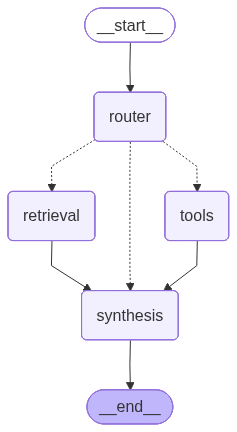
</div>

In [25]:
# !curl -o src/manual.txt "https://confident-bucket.s3.us-east-1.amazonaws.com/manual.txt"

In [26]:
from src.langgraph_rag_agent import app
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

initial_state = {
    "query": "",
    "selected_tools": [],
    "retrieved_context": "",
    "tool_outputs": [],
    "next_action": "",
}

def rag_query(query: str):
    """Run a query through the RAG system"""

    state = {"messages": [HumanMessage(content=query)]}
    result = app.invoke(state)
    return {
        "response": result["messages"][-1].content,
        "retrieved_context": result.get("retrieved_context", ""),
        "route": result.get("next_action", ""),
        "tool_outputs": result.get("tool_outputs", []),
    }

In [27]:
rag_query("What is the average heart rate of the user?")

{'response': 'The average heart rate of the user is 94 beats per minute.',
 'retrieved_context': '',
 'route': 'tools',
 'tool_outputs': ['get_last_day_average_heart_rate: 94']}

In [28]:
rag_query("What are your top tips for fitness?")

{'response': 'Here are some top tips for fitness based on the provided context:\n\n1. **Track Your Daily Steps**: Monitoring your daily step count is a fundamental way to ensure you are engaging in enough physical activity. Aim for a goal that suits your lifestyle, and remember that breaking up long periods of sitting with short walks can be beneficial.\n\n2. **Incorporate Variety in Your Activities**: Instead of just focusing on long walks, mix up your routine with different types of exercises. This can include short bursts of walking every half hour, which can help improve blood glucose control and keep your metabolism active.\n\n3. **Listen to Your Body**: Pay attention to how you feel during and after physical activity. This awareness can help you avoid injuries and adjust your routine as needed. \n\n4. **Invest in Good Footwear**: Wearing supportive shoes is crucial for preventing injuries and reducing strain on your joints. Make sure your footwear is appropriate for the type of a

In [29]:
rag_dataset = EvaluationDataset(
    goldens=goldens #same ones as before
)

In [30]:
for golden in rag_dataset.goldens[0:2]:
    output = rag_query(golden.input) #generate some real outputs, might take a while...
    test_case = LLMTestCase(
        input=golden.input,
        actual_output=output['response'], # replace with your LLM app
        retrieval_context=[output['retrieved_context']] # current setup this is returned as a single string.
    )
    rag_dataset.add_test_case(test_case)

In [31]:
rag_results = evaluate(rag_dataset.test_cases, metrics=metrics)

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Contextual Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

Output()



Metrics Summary

  - ✅ Answer Relevancy (score: 0.9166666666666666, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 0.92 because the response effectively addresses the concern about the cough, providing relevant advice and information. However, the mention of routine check-ups, while generally useful, is not directly related to the specific concern about the cough, slightly affecting the score., error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because there are no contradictions between the actual output and the retrieval context. Everything aligns perfectly, showcasing a high level of accuracy and consistency. Keep up the great work!, error: None)
  - ❌ Contextual Relevancy (score: 0.16666666666666666, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The score is 0.17 because the majority of the context focuses on topics unrelated to a cough, such as heart rat

✓ Evaluation completed 🎉! (time taken: 6.68s | token cost: 0.05010250000000001 USD)
» Test Results (2 total tests):
   » Pass Rate: 0.0% | Passed: 0 | Failed: 2

 ================================================================================ 

» What to share evals with your team, or a place for your test cases to live? ❤️ 🏡
  » Run 'deepeval view' to analyze and save testing results on Confident AI.

In [32]:
df_rag = reformat_results(rag_results)

In [33]:
df_rag

,test_case,Answer Relevancy_value,Contextual Relevancy_value,Faithfulness_value
0,test_case_0,0.916667,0.166667,1.0
1,test_case_1,0.941176,0.000000,1.0


# 4. Execution (More Examples)

## 4.1 Unit Tests

In [34]:
from deepeval import assert_test
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.metrics import GEval

def test_correctness():
    correctness_metric = GEval(
        name="Correctness",
        criteria="Determine if the 'actual output' is correct based on the 'expected output'.",
        evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.EXPECTED_OUTPUT],
        threshold=0.5
    )
    test_case = LLMTestCase(
        input="I have a persistent cough and fever. Should I be worried?",
        # Replace this with the actual output from your LLM application
        actual_output="A persistent cough and fever could be a viral infection or something more serious. See a doctor if symptoms worsen or don't improve in a few days.",
        expected_output="A persistent cough and fever could indicate a range of illnesses, from a mild viral infection to more serious conditions like pneumonia or COVID-19. You should seek medical attention if your symptoms worsen, persist for more than a few days, or are accompanied by difficulty breathing, chest pain, or other concerning signs."
    )
    assert_test(test_case, [correctness_metric])

In [35]:
!deepeval test run src/test_basic.py

I0000 00:00:1760993979.877800   96943 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


Evaluating 1 test case(s) in parallel ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% 0:00:000m
Evaluating 1 test case(s) in parallel ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% 0:00:00
Evaluating 1 test case(s) in parallel ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% 0:00:00
Evaluating 1 test case(s) in parallel ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% 0:00:00
Evaluating 1 test case(s) in parallel ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% 0:00:00
Evaluating 1 test case(s) in parallel ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% 0:00:00
Evaluating 1 test case(s) in parallel ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% 0:00:00
Evaluating 1 test case(s) in parallel ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% 0:00:00
Evaluating 1 test case(s) in parallel ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% 0:00:00
Evaluating 1 test case(s) in parallel ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% 0:00:00
Evaluating 1 test case(s) in parallel ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% 0:00:01
Evaluating 1 test case(s) in parallel ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% 0:00:01
Evaluating 1 test case(s) 

## 4.2 Callback Handler
If you are on Confident-AI, but you need a corporate email ... BOO!

In [36]:
%%skip
from deepeval.integrations.langchain import CallbackHandler
from deepeval.metrics import TaskCompletionMetric


def run_rag_query(query: str):
    """Run a query through the RAG system"""

    initial_state["messages"] = [HumanMessage(content=query)]

    result = app.invoke(
        initial_state,
        config={
            "callbacks": [
                CallbackHandler(
                    metrics=[
                        TaskCompletionMetric(strict_mode=True, async_mode=False)
                    ]
                )
            ]  # pass the metrics to the callback handler
        },
    )

    final_message = result["messages"][-1]
    return final_message.content


## 4.3 Batch
You can schedule these eval runs as part of an online eval/monitoring monitoring pipeline.

<div>
<img src="deepeval-airflow.svg" width="600"/>
</div>